# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## 0.1. Helper Functions

## 0.2. Load Data

In [2]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [3]:
df_raw.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


# 1.0. Descrição dos Dados

In [4]:
df1 = df_raw.copy()

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1. Dimensão dos Dados

In [6]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de linhas: 381109
Número de Colunas: 12


## 1.2. Tipo dos Dados

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Valida NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Análise Descritiva

In [9]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [10]:
# Tendencia central - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - std, min, max, range, knew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
1,13,Female,41,1,15.0,1,1-2 Year,No,31409.0,14.0,221,0
2,18,Female,25,1,35.0,1,< 1 Year,No,46622.0,152.0,299,0
3,31,Female,26,1,8.0,0,< 1 Year,No,2630.0,160.0,136,0
4,39,Male,45,1,8.0,0,1-2 Year,Yes,42297.0,124.0,264,0


In [13]:
df2['vehicle_age'].drop_duplicates()

0      < 1 Year
1      1-2 Year
27    > 2 Years
Name: vehicle_age, dtype: object

In [14]:
# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                   if x == '1-2 Year' else 'below_1_year' )

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 ) 

# 3.0. Filtragem dos Dados

In [15]:
df3 = df2.copy()

Como não tem dados visivelmente discrepantes ou com outlayers não farei filtragem neste ciclo.

# 4.0. Análise Exploratória dos Dados

In [16]:
df4 = df3.copy()

## 4.1. Análise Univariada

<AxesSubplot:xlabel='response', ylabel='age'>

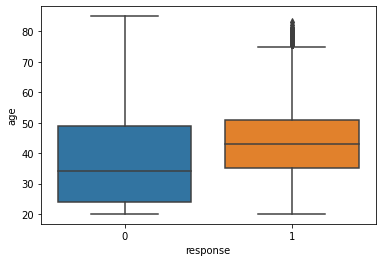

In [17]:
# 'age'
sns.boxplot( x='response', y='age', data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

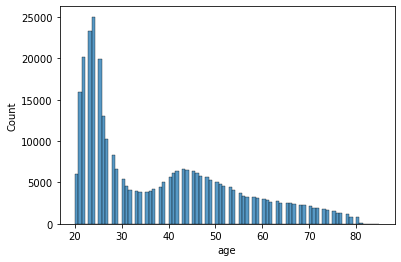

In [18]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

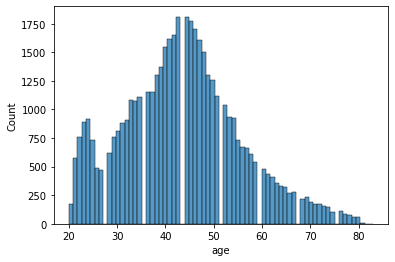

In [19]:
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux01 )

In [20]:
# 'annual_premium'

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

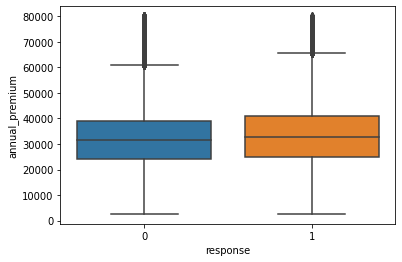

In [21]:
# 'annual_premium'
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

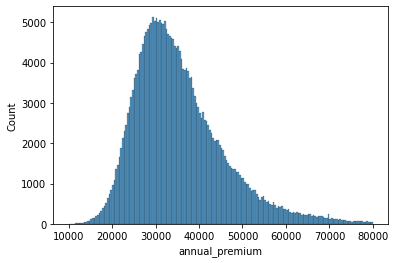

In [22]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

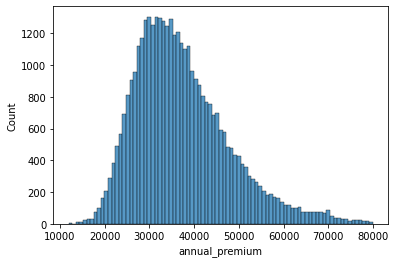

In [23]:
aux01 = aux.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux01 )

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


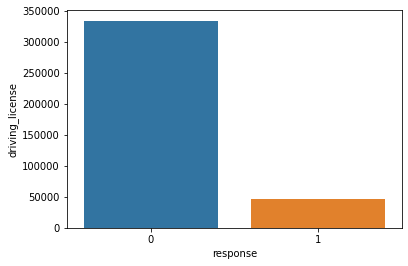

In [24]:
# 'driving_license'
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
sns.barplot( x='response', y='driving_license', data=aux)
aux.head()

In [ ]:
# 'gender'

In [ ]:
# 'region_code'

In [ ]:
# 'previously_insured'

In [ ]:
# 'vehicle_age'

In [ ]:
# 'vehicle_damage'

In [ ]:
# 'policy_sales_channel'

In [ ]:
# 'vintage'

In [ ]:
# 'response'

## 4.2. Análise Bivariada

# 5.0. Feature Selection

# 6.0. Preparação dos Dados

# 7.0. Modelagem de machine learning

# 8.0. Ajuste fino de hiperparâmetros

# 9.0. Converter o desempenho do modelo em valores de negócios

# 10.0. Implantar o Modelo em Produção